In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from fbprophet.plot import plot_plotly, plot_components_plotly
from fbprophet import Prophet
from statsmodels.tsa.seasonal import seasonal_decompose as sd
import plotly.graph_objects as go
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import missingno as msno

In [3]:
df_feature = pd.read_csv('features.csv', parse_dates=[1])
df_train = pd.read_csv('train.csv', parse_dates=[2])

In [4]:
# missing data
df_feature.drop(['MarkDown1','MarkDown2','MarkDown3','MarkDown4','MarkDown5'], axis=1, inplace=True)
df_feature['CPI'].ffill(inplace=True)
df_feature['Unemployment'].ffill(inplace=True) 

In [5]:
df_feature_train = df_feature[df_feature['Date'].between('2010-02-05', '2012-10-26')]
df_train_group = df_train.groupby(['Store', 'Date']).mean()[['Weekly_Sales', 'IsHoliday']]
df_train_group.reset_index(inplace=True)
train = df_train_group.merge(df_feature_train, on=['Store', 'Date'])
df = train.groupby('Date').mean().drop('Store', axis=1).reset_index()

In [6]:
ts = df[['Date','Weekly_Sales']]
ts.columns = ["ds","y"]
ts.head()

,ds,y
0,2010-02-05,16209.922128
1,2010-02-12,15794.946081
2,2010-02-19,15645.953012
3,2010-02-26,14397.682819
4,2010-03-05,15376.871198


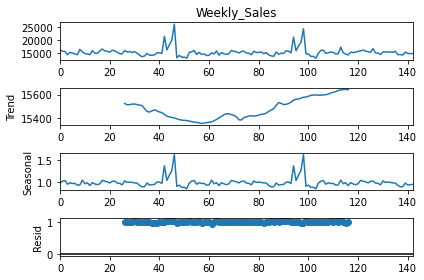

In [7]:
# Visualize Residuals, Seasonal, Trend, and level
res = sm.tsa.seasonal_decompose(df['Weekly_Sales'], period=52, model="multiplicative")
res.plot()
plt.show()

In [8]:
train=ts[:114]
test=ts[114:]

## Fitting Prophet Model

In [21]:
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
def RMSE(y_test, y_pred):
    mse = mean_squared_error(y_test, y_pred)
    rmse = sqrt(mse)
    return rmse

In [10]:
def RMSPE(y_true, y_pred):
    return np.sqrt(np.nanmean(np.square(((y_true - y_pred) / y_true))))*100

In [11]:
m = Prophet(yearly_seasonality = True, seasonality_prior_scale=20, holidays_prior_scale=20, changepoint_prior_scale=0.02)
m.fit(train)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [12]:
# Display the future data (29 weeks)
future = m.make_future_dataframe(periods=29, freq='W')
future.tail()

,ds
138,2012-09-23
139,2012-09-30
140,2012-10-07
141,2012-10-14
142,2012-10-21


In [13]:
# Predict future sales
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
138,2012-09-23,14069.725131,12518.625441,15646.265001
139,2012-09-30,14456.537250,12849.272834,16009.966182
140,2012-10-07,14897.848631,13236.446025,16547.937785
141,2012-10-14,14907.111131,13275.401952,16511.632112
142,2012-10-21,14625.890759,12972.282935,16215.152990


In [14]:
print('rmse', RMSE(test['y'], forecast[114:]['yhat']))
print('rmspe', RMSPE(test['y'], forecast[114:]['yhat']))

rmse 497.5800824754755
rmspe 3.292152325164933


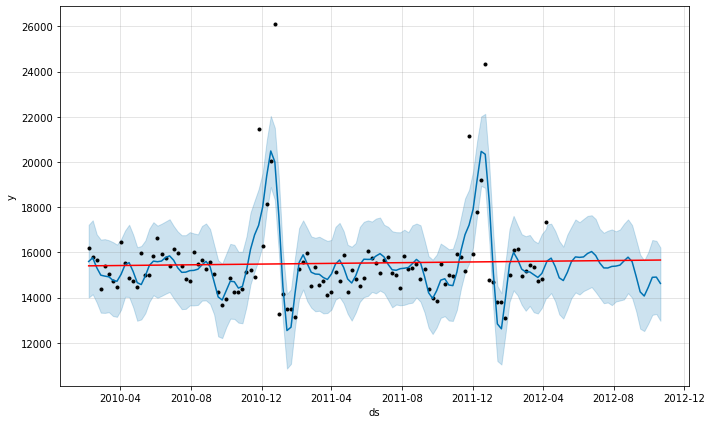

In [15]:
from prophet.plot import add_changepoints_to_plot
fig1 = m.plot(forecast)
a = add_changepoints_to_plot(fig1.gca(), m, forecast)

<AxesSubplot:xlabel='ds'>

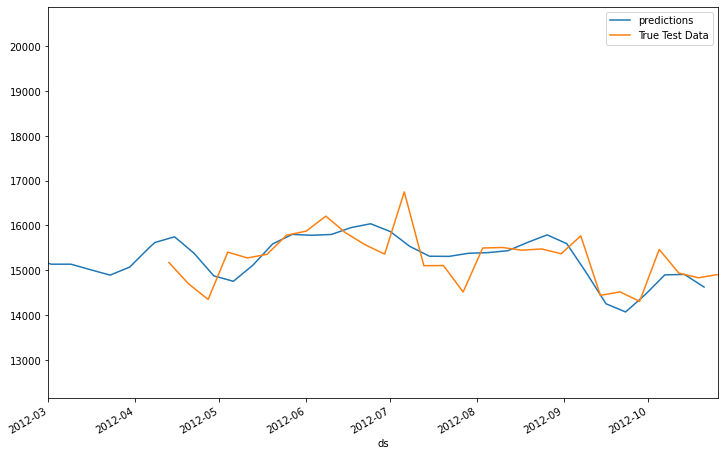

In [16]:
ax=forecast.plot(x='ds',y='yhat',legend=True,label='predictions',figsize=(12,8))
test.plot(x='ds',y='y',legend=True,label='True Test Data',
          ax=ax,xlim=('2012-03-01','2012-10-26'))

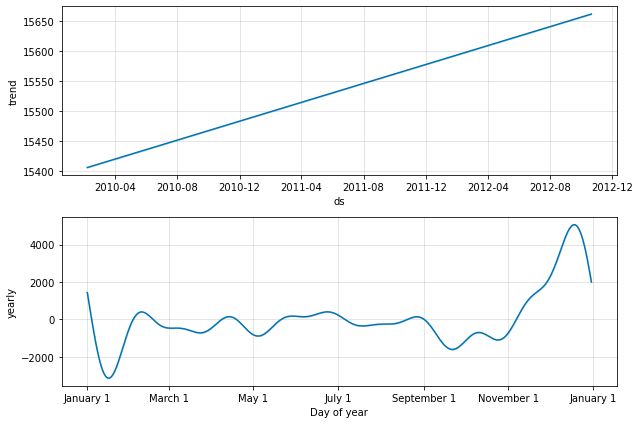

In [17]:
fig2 = m.plot_components(forecast)

## Hyperparameter Tuning

In [23]:
# Python
import itertools
import numpy as np
import pandas as pd
from prophet.diagnostics import cross_validation
from prophet.diagnostics import performance_metrics

param_grid = {  
    'changepoint_prior_scale': [ 0.01, 0.1],
    'seasonality_prior_scale': [1.0, 10.0, 20.0],
    'holidays_prior_scale': [10, 20, 30]}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmse = []  # Store the RMSEs for each params here
mape = []

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params, daily_seasonality=True, weekly_seasonality=True).fit(ts)
    df_cv = cross_validation(m, horizon = '180 days')
    df_p = performance_metrics(df_cv, rolling_window=1)
    mape.append(df_p['mape'].values[0])
    rmse.append(df_p['rmse'].values[0])

INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


INFO:prophet:Making 4 forecasts with cutoffs between 2011-08-03 00:00:00 and 2012-04-29 00:00:00


In [26]:
# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['mape'] = mape
tuning_results['rmse'] = rmse
tuning_results.columns=['changepoint','seasonality','holidays','mape','rmse']
tuning_results.sort_values('rmse')

,changepoint,seasonality,holidays,mape,rmse
11,0.10,1.0,30,0.047705,1224.923660
10,0.10,1.0,20,0.047705,1224.923660
9,0.10,1.0,10,0.047705,1224.923660
14,0.10,10.0,30,0.047833,1225.726073
13,0.10,10.0,20,0.047833,1225.726073
12,0.10,10.0,10,0.047833,1225.726073
17,0.10,20.0,30,0.047823,1226.186090
15,0.10,20.0,10,0.047823,1226.186090
16,0.10,20.0,20,0.047823,1226.186090
8,0.01,20.0,30,0.050861,1252.111868


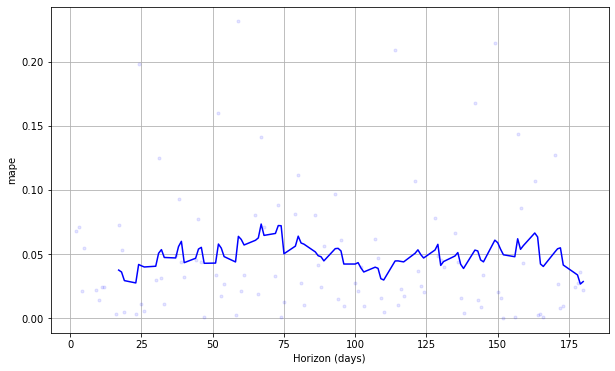

In [25]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')